In [1]:
import numpy as np
import tensorflow as tf
from tensorflow.contrib.framework.python.ops.variables import get_or_create_global_step
from tensorflow.python.platform import tf_logging as logging
import inception_preprocessing
import vgg_preprocessing
from inception_resnet_v2 import inception_resnet_v2, inception_resnet_v2_arg_scope
import os
import time

slim = tf.contrib.slim

In [3]:
# prepare label
place = ['house', 'lab', 'office']
# place = place[0:1]
num = ['4', '5', '6']
# num = ['1', '2', '3']
kind = ['left', 'right']

path = '../labels/'

label = np.array([])

for p in place:
    lab_list = os.listdir(path + p)
    for lab in lab_list:
        ali = lab
        if 'obj' in ali:
            ali = ali.replace('.npy', '')
            for k in kind:
                if k in ali:
                    if p == 'lab':
                        for n in range(5, 9):
                            if str(n) in ali:
                                if len(label) == 0:
                                    label = np.load(path + p + '/' + lab)
                                else:
                                    label = np.concatenate([label, np.load(path + p + '/' + lab)])
                    else:
                        for n in num:
                            if n in ali:
                                if len(label) == 0:
                                    label = np.load(path + p + '/' + lab)
                                else:
                                    label = np.concatenate([label, np.load(path + p + '/' + lab)])
label = label.astype(int)
# label = label[0:2]
# print(len(label))
img_num = len(label)

NameError: name 'os' is not defined

In [13]:
import matplotlib.pyplot as plt

import tensorflow.contrib.slim.nets
vgg = tf.contrib.slim.nets.vgg

from sklearn.metrics import precision_recall_curve

plt.style.use('ggplot')

log_dir = '../log'
log_eval = '../log_eval_test'
batch_size = 32
num_epochs = 1
checkpoint_file = tf.train.latest_checkpoint(log_dir)

#State the number of classes to predict:
obj = { 'free':0,
        'computer':1,
        'cellphone':2,
        'coin':3,
        'ruler':4,
        'thermos-bottle':5,
        'whiteboard-pen':6,
        'whiteboard-eraser':7,
        'pen':8,
        'cup':9,
        'remote-control-TV':10,
        'remote-control-AC':11,
        'switch':12,
        'windows':13,
        'fridge':14,
        'cupboard':15,
        'water-tap':16,
        'toy':17,
        'kettle':18,
        'bottle':19,
        'cookie':20,
        'book':21,
        'magnet':22,
        'lamp-switch':23}

num_classes = len(obj)
obj_by_value = {}

for key in obj.keys():
    obj_by_value[obj[key]] = key

#Create log_dir for evaluation information
if not os.path.exists(log_eval):
    os.mkdir(log_eval)

#Just construct the graph from scratch again
with tf.Graph().as_default() as graph:
    tf.logging.set_verbosity(tf.logging.INFO)

    #Create some information about the training steps
    num_batches_per_epoch = int(img_num / batch_size)
    num_steps_per_epoch = num_batches_per_epoch
    
    # prepare image FIFOQueue
    height = 224
    width = 224
    num_threads = 4

    image_names = tf.train.match_filenames_once('../frames/test/*/*/*hand/Image*.png')
    image_queue = tf.train.string_input_producer(image_names, shuffle = False)

    image_reader = tf.WholeFileReader()
    _, image_value = image_reader.read(image_queue)

    image_tf = tf.image.decode_png(image_value, channels = 3)
    image_tf = tf.image.resize_images(image_tf, [height, width])
    image_tf.set_shape((height, width, 3))
#     image_tf = tf.subtract(tf.multiply(2.0, tf.divide(image_tf, 255.0)), 1.0)
#     image_tf = inception_preprocessing.preprocess_image(image_tf, height, width, is_training = True)

    # prepare label FIFOQueue
    label_tf = tf.convert_to_tensor(label, dtype = tf.int32)
    label_queue = tf.train.slice_input_producer([label_tf], shuffle = False)
    
    # prepare original image for visualize
    raw_image = tf.image.decode_png(image_value, channels = 3)
    raw_image = tf.expand_dims(raw_image, 0)
    raw_image = tf.image.resize_nearest_neighbor(raw_image, [height, width])
    raw_image = tf.squeeze(raw_image)
    
    # creating a batch of images and labels
    batch_image, batch_raw_image, batch_label = tf.train.batch([[image_tf], [raw_image], label_queue], 
                                                                batch_size = batch_size, 
                                                                num_threads = num_threads,
                                                                capacity = num_threads * batch_size,
                                                                enqueue_many = True,
                                                                allow_smaller_final_batch = True)
    
    
    #Now create the inference model but set is_training=False
    logits, end_points = vgg.vgg_16(batch_image, 
                                    num_classes = num_classes,
                                    is_training = False)

    #get all the variables to restore from the checkpoint file and create the saver function to restore
    variables_to_restore = slim.get_variables_to_restore()
    saver = tf.train.Saver(variables_to_restore)
    def restore_fn(sess):
        return saver.restore(sess, checkpoint_file)

    #Just define the metrics to track without the loss or whatsoever
    probabilities = tf.nn.softmax(logits)
    predictions = tf.argmax(probabilities, 1)
    accuracy, accuracy_update = tf.contrib.metrics.streaming_accuracy(predictions, batch_label)
    metrics_op = tf.group(accuracy_update, probabilities)
    
    #precision and recall
#     precision = tf.metrics.precision(predictions, batch_label)
#     recall = tf.metrics.recall(predictions, batch_label)
    
    #Create the global step and an increment op for monitoring
    global_step = get_or_create_global_step()
    global_step_op = tf.assign(global_step, global_step + 1) #no apply_gradient method so manually increasing the global_step

    #Create a evaluation step function
    def eval_step(sess, metrics_op, global_step):
        start_time = time.time()
        _, global_step_count, accuracy_value, prediction = sess.run([metrics_op, global_step_op, accuracy, predictions])
        time_elapsed = time.time() - start_time

        #Log some information
        logging.info('Global Step %s: Streaming Accuracy: %.4f (%.2f sec/step)', global_step_count, accuracy_value, time_elapsed)
        if global_step_count % 33 == 0:
            for i in range(batch_size):
                logging.info('Current Streaming Predictions: %d', prediction[i])
        return prediction, accuracy_value

    #Define some scalar quantities to monitor
    tf.summary.scalar('Validation_Accuracy', accuracy)
    my_summary_op = tf.summary.merge_all()

    #Get your supervisor
    sv = tf.train.Supervisor(logdir = log_eval, summary_op = None, saver = None, init_fn = restore_fn)
    
    pred_4_curve = []
    
    #Now we are ready to run in one session
    with sv.managed_session() as sess:
        '''
        accuracry section
        '''
        for step in range(num_steps_per_epoch * num_epochs):
            global_step_counts = sess.run(sv.global_step)
            #Compute summaries every 10 steps and continue evaluating
            if step % 10 == 0:
                pred, _ = eval_step(sess, metrics_op = metrics_op, global_step = sv.global_step)
                pred_4_curve += [pred]
                summaries = sess.run(my_summary_op)
                sv.summary_computed(sess, summaries)

            #Otherwise just run as per normal
            else:
                eval_step(sess, metrics_op = metrics_op, global_step = sv.global_step)

        #At the end of all the evaluation, show the final accuracy
        logging.info('Final Streaming Accuracy: %.4f', sess.run(accuracy))
    
        '''
        Now we want to visualize the last batch's images just to see what our model has predicted
        
        '''
#         pred_raw_image, pred_label, predicts = sess.run([batch_raw_image, batch_label, predictions])
#         for i in range(batch_size):
#             image, label, predict = pred_raw_image[i], pred_label[i], predicts[i]
#             prediction_name, label_name = obj_by_value[int(predict)], obj_by_value[int(label)]
#             text = 'Prediction: %s \n Ground Truth: %s' %(prediction_name, label_name)
#             print(text)
        '''
        test label and image are right
        
        '''
#         for step in range(200):
#             pred_raw_image, pred_label = sess.run([batch_raw_image, batch_label])
#             for i in range(batch_size):
#                 img_plot = plt.imshow(pred_raw_image[i])

#                 #Set up the plot and hide axes
#                 plt.title(obj_by_value[int(pred_label[i])])
#                 img_plot.axes.get_yaxis().set_ticks([])
#                 img_plot.axes.get_xaxis().set_ticks([])
#                 plt.show()

#         logging.info('Model evaluation has completed! Visit TensorBoard for more information regarding your evaluation.')

INFO:tensorflow:Restoring parameters from ../log\model.ckpt-0
INFO:tensorflow:Starting standard services.
INFO:tensorflow:Starting queue runners.
INFO:tensorflow:global_step/sec: 0
INFO:tensorflow:Global Step 1: Streaming Accuracy: 0.0000 (0.36 sec/step)
INFO:tensorflow:Global Step 2: Streaming Accuracy: 1.0000 (0.42 sec/step)
INFO:tensorflow:Global Step 3: Streaming Accuracy: 0.9375 (0.35 sec/step)
INFO:tensorflow:Global Step 4: Streaming Accuracy: 0.9583 (0.37 sec/step)
INFO:tensorflow:Global Step 5: Streaming Accuracy: 0.9062 (0.37 sec/step)
INFO:tensorflow:Global Step 6: Streaming Accuracy: 0.8125 (0.38 sec/step)
INFO:tensorflow:Global Step 7: Streaming Accuracy: 0.7552 (0.38 sec/step)
INFO:tensorflow:Global Step 8: Streaming Accuracy: 0.7098 (0.38 sec/step)
INFO:tensorflow:Global Step 9: Streaming Accuracy: 0.7461 (0.37 sec/step)
INFO:tensorflow:Global Step 10: Streaming Accuracy: 0.7674 (0.37 sec/step)
INFO:tensorflow:Current Streaming Predictions: 18
INFO:tensorflow:Current Stre

In [56]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import average_precision_score
import matplotlib.pyplot as plt
%matplotlib inline

def plot_precision_recall_curve(num_classes, y_true, prob_pred):
    precision = {}
    recall = {}
    average_precision = {}

    for i in range(num_classes):
        precision[i], recall[i], _ = precision_recall_curve(y_true[:][i], prob_pred[:][i])
        average_precision[i] = average_precision_score(y_true[:][i], prob_pred[:][i], average='macro')
        
    # A "micro-average": quantifying score on all classes jointly
    precision['micro'], recall['micro'], _ = precision_recall_curve(y_true.ravel(), prob_pred.ravel())
    average_precision['micro'] = average_precision_score(y_true, prob_pred, average='micro')
    
    # Start plotting
    lines = []
    labels = []
    plt.figure(figsize=(16, 9))
    
    # Micro-average precision-recall curve
    l, = plt.plot(recall["micro"], precision["micro"], color='gold', lw=2)
    lines.append(l)
    labels.append('Micro-average Precision-recall (area = {0:0.2f})'
                  ''.format(average_precision["micro"]))
    
    # Precision-recall curve per class
    for i in range(num_classes):
        l, = plt.plot(recall[i], precision[i], lw=2)
        lines.append(l)
        labels.append('Precision-recall for class {0} (area = {1:0.2f})'
                      ''.format(i, average_precision[i]))
    
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Extension of Precision-Recall curve to multi-class')
    plt.legend(lines, labels, loc='upper right', prop=dict(size=10), bbox_to_anchor=(1.3, 1.01))
    plt.show()
    
    return precision, recall, average_precision

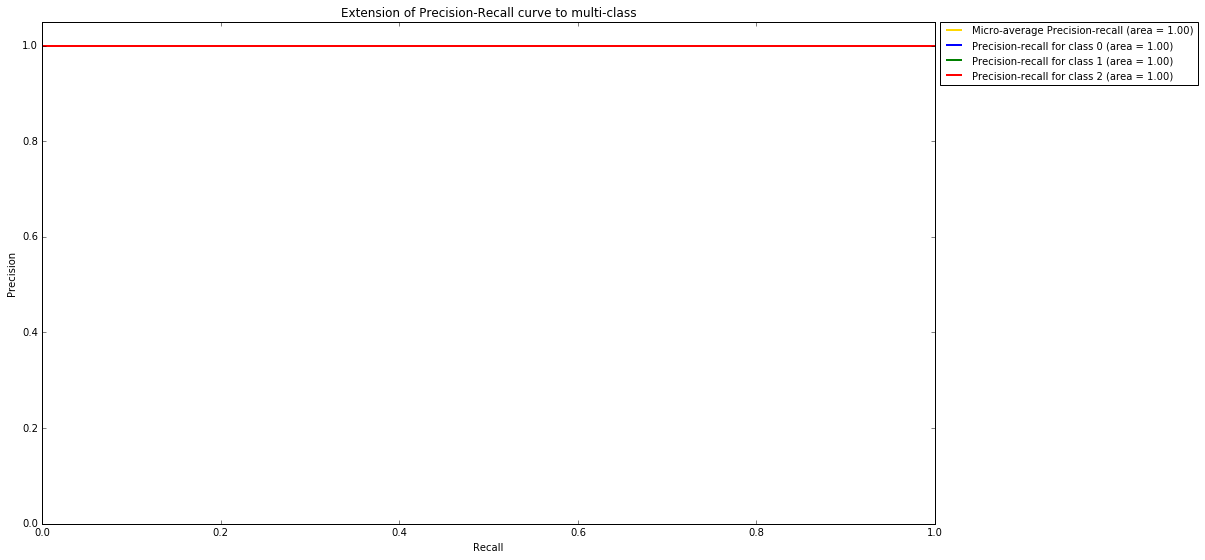

In [57]:
# num_classes = 3
# labels = [1, 2, 2, 3, 3]
# classes = [1, 2, 3]
# pred_4_curve = [[0.97, 0.01, 0.02], 
#                 [0.1, 0.8, 0.1], 
#                 [0.1, 0.8, 0.1], 
#                 [0.1, 0.1, 0.8], 
#                 [0.1, 0.1, 0.8]]


precision, recall, average_precision = plot_precision_recall_curve(num_classes = 3, 
                                                                   y_true = label_binarize(labels, classes = classes), 
                                                                   prob_pred = np.array(pred_4_curve))

In [49]:
l = label_binarize(labels, classes = classes)
p = pred_4_curve
print(p[0, 0])
print(l[0, 0])

TypeError: list indices must be integers or slices, not tuple

In [ ]:
import matplotlib.pyplot as plt

'''Inception-Resnet-v2 model testing'''

plt.style.use('ggplot')

log_dir = '../log'
log_eval = '../log_eval_test'
batch_size = 32
num_epochs = 1
checkpoint_file = tf.train.latest_checkpoint(log_dir)

#State the number of classes to predict:
obj = { 'free':0,
        'computer':1,
        'cellphone':2,
        'coin':3,
        'ruler':4,
        'thermos-bottle':5,
        'whiteboard-pen':6,
        'whiteboard-eraser':7,
        'pen':8,
        'cup':9,
        'remote-control-TV':10,
        'remote-control-AC':11,
        'switch':12,
        'windows':13,
        'fridge':14,
        'cupboard':15,
        'water-tap':16,
        'toy':17,
        'kettle':18,
        'bottle':19,
        'cookie':20,
        'book':21,
        'magnet':22,
        'lamp-switch':23}

num_classes = len(obj)
obj_by_value = {}

for key in obj.keys():
    obj_by_value[obj[key]] = key

#Create log_dir for evaluation information
if not os.path.exists(log_eval):
    os.mkdir(log_eval)

#Just construct the graph from scratch again
with tf.Graph().as_default() as graph:
    tf.logging.set_verbosity(tf.logging.INFO)

    #Create some information about the training steps
    num_batches_per_epoch = int(img_num / batch_size)
    num_steps_per_epoch = num_batches_per_epoch
    
    # prepare image FIFOQueue
    height = 299
    width = 299
    num_threads = 4

    image_names = tf.train.match_filenames_once('../frames/test/*/*/*hand/Image*.png')
    image_queue = tf.train.string_input_producer(image_names, shuffle = False)

    image_reader = tf.WholeFileReader()
    _, image_value = image_reader.read(image_queue)

    image_tf = tf.image.decode_png(image_value, channels = 3)
    image_tf = tf.image.resize_images(image_tf, [height, width])
    image_tf.set_shape((height, width, 3))
    image_tf = tf.subtract(tf.multiply(2.0, tf.divide(image_tf, 255.0)), 0.5)
#     image_tf = inception_preprocessing.preprocess_image(image_tf, height, width, is_training = True)

    # prepare label FIFOQueue
    label_tf = tf.convert_to_tensor(label, dtype = tf.int32)
    label_queue = tf.train.slice_input_producer([label_tf], shuffle = False)
    
    # prepare original image for visualize
    raw_image = tf.image.decode_png(image_value, channels = 3)
    raw_image = tf.expand_dims(raw_image, 0)
    raw_image = tf.image.resize_nearest_neighbor(raw_image, [height, width])
    raw_image = tf.squeeze(raw_image)
    
    # creating a batch of images and labels
    batch_image, batch_raw_image, batch_label = tf.train.batch([[image_tf], [raw_image], label_queue], 
                                                                batch_size = batch_size, 
                                                                num_threads = num_threads,
                                                                enqueue_many = True,
                                                                allow_smaller_final_batch = True)
    
    
    #Now create the inference model but set is_training=False
    with slim.arg_scope(inception_resnet_v2_arg_scope()):
        logits, end_points = inception_resnet_v2(batch_image, num_classes = num_classes, is_training = True)
    
    #get all the variables to restore from the checkpoint file and create the saver function to restore
    variables_to_restore = slim.get_variables_to_restore()
    saver = tf.train.Saver(variables_to_restore)
    def restore_fn(sess):
        return saver.restore(sess, checkpoint_file)

    #Just define the metrics to track without the loss or whatsoever
    predictions = tf.argmax(end_points['Predictions'], 1)
    accuracy, accuracy_update = tf.contrib.metrics.streaming_accuracy(predictions, batch_label)
    metrics_op = tf.group(accuracy_update)

    #Create the global step and an increment op for monitoring
    global_step = get_or_create_global_step()
    global_step_op = tf.assign(global_step, global_step + 1) #no apply_gradient method so manually increasing the global_step

    #Create a evaluation step function
    def eval_step(sess, metrics_op, global_step):
        start_time = time.time()
        _, global_step_count, accuracy_value, prediction = sess.run([metrics_op, global_step_op, accuracy, predictions])
        time_elapsed = time.time() - start_time

        #Log some information
        logging.info('Global Step %s: Streaming Accuracy: %.4f (%.2f sec/step)', global_step_count, accuracy_value, time_elapsed)
        if global_step % 10 == 0:
            for i in range(batch_size):
                logging.info('Current Streaming Predictions: %d', prediction[i])
        return accuracy_value

    #Define some scalar quantities to monitor
    tf.summary.scalar('Validation_Accuracy', accuracy)
    my_summary_op = tf.summary.merge_all()

    #Get your supervisor
    sv = tf.train.Supervisor(logdir = log_eval, summary_op = None, saver = None, init_fn = restore_fn)

    #Now we are ready to run in one session
    with sv.managed_session() as sess:
        '''
        accuracry section
        '''
#         for step in range(num_steps_per_epoch * num_epochs):
#             sess.run(sv.global_step)
#             #Compute summaries every 10 steps and continue evaluating
#             if step % 10 == 0:
#                 eval_step(sess, metrics_op = metrics_op, global_step = sv.global_step)
#                 summaries = sess.run(my_summary_op)
#                 sv.summary_computed(sess, summaries)

#             #Otherwise just run as per normal
#             else:
#                 eval_step(sess, metrics_op = metrics_op, global_step = sv.global_step)

#         #At the end of all the evaluation, show the final accuracy
#         logging.info('Final Streaming Accuracy: %.4f', sess.run(accuracy))
    
        '''
        Now we want to visualize the last batch's images just to see what our model has predicted
        
        '''
#         pred_raw_image, pred_label, predicts = sess.run([batch_raw_image, batch_label, predictions])
#         for i in range(batch_size):
#             image, label, predict = pred_raw_image[i], pred_label[i], predicts[i]
#             prediction_name, label_name = obj_by_value[int(predict)], obj_by_value[int(label)]
#             text = 'Prediction: %s \n Ground Truth: %s' %(prediction_name, label_name)
#             print(text)
        '''
        test label and image are right
        
        '''
#         for step in range(200):
#             pred_raw_image, pred_label = sess.run([batch_raw_image, batch_label])
#             for i in range(batch_size):
#                 img_plot = plt.imshow(pred_raw_image[i])

#                 #Set up the plot and hide axes
#                 plt.title(obj_by_value[int(pred_label[i])])
#                 img_plot.axes.get_yaxis().set_ticks([])
#                 img_plot.axes.get_xaxis().set_ticks([])
#                 plt.show()

#         logging.info('Model evaluation has completed! Visit TensorBoard for more information regarding your evaluation.')

label data loaded, and the number of labels is: 4056
num_batches_per_epoch: 253
